In [71]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import pandas as pd
import numpy as np
from scipy import stats
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import initializers
from keras.models import Sequential
from keras.layers import Dense, Activation, LSTM, Embedding
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import textwrap
from matplotlib.ticker import MultipleLocator

In [2]:
def normalize_predictions(preds, test, concat): 
    norms = []
    
    #max-scale intensities
    for arr in preds:
        max_intensity = np.max(arr)
        normalized_arr = arr / max_intensity
        norms.append(normalized_arr)

    norms = np.array(norms) # convert to numpy-array

    fix = []
    
    # make sure that -1 values in prediction match -1 values in test 
    for y_pred_arr, y_test_arr in zip(norms, test):
        fixed_arr = np.where((y_test_arr == -1), -1, y_pred_arr)
        fix.append(fixed_arr)

    fix = np.array(fix)

    p_fil = []
    t_fil = []
    
    # remove -1 values to not falsely boost accuracy scores
    for y_pred_arr, y_test_arr in zip(fix, test):
        mask = (y_pred_arr != -1)
        filtered_y_pred_arr = y_pred_arr[mask]
        filtered_y_test_arr = y_test_arr[mask]
        p_fil.append(filtered_y_pred_arr)
        t_fil.append(filtered_y_test_arr)
    if concat:
        t_fil = np.concatenate(t_fil) 
        p_fil = np.concatenate(p_fil)
    return[p_fil,t_fil]

In [3]:
def norm_dot_product(v1, v2):
    dot_product = np.dot(v1,v2)
    
    norm1 = np.linalg.norm(v1)
    norm2 = np.linalg.norm(v2)
    
    return dot_product/(norm1*norm2)

In [4]:
X = np.load('X_final.npy')
print(X)
print(X.shape)
print(" ")
y = np.load('y_final.npy')
print(y)
print(y.shape)

[[ 5  3  7 ... -1 -1  3]
 [ 5  3  7 ... -1 -1  3]
 [20  5 16 ... -1 -1  2]
 ...
 [25 19  1 ... -1 -1  2]
 [25 19  1 ... -1 -1  2]
 [25 19  1 ... -1 -1  2]]
(3892724, 31)
 
[[ 0.          0.04226476  0.06942312 ... -1.         -1.
  -1.        ]
 [ 0.          0.0300348   0.05937908 ... -1.         -1.
  -1.        ]
 [ 0.          0.          0.         ... -1.         -1.
  -1.        ]
 ...
 [ 0.          0.3759307   0.00947882 ... -1.         -1.
  -1.        ]
 [ 0.          0.35836761  0.00580796 ... -1.         -1.
  -1.        ]
 [ 0.          0.34606871  0.00517434 ... -1.         -1.
  -1.        ]]
(3892724, 58)


In [5]:
#splitting the data;
X_trainBeginning, X_testEval, y_trainBeginning, y_testEval = train_test_split(X, y, test_size=0.2, shuffle=False)

In [6]:
X_trainBeginning = np.array(X_trainBeginning)
X_testEval = np.array(X_testEval)
y_trainBeginning = np.array(y_trainBeginning)
y_testEval = np.array(y_testEval)
print(X_trainBeginning.shape)
print(X_testEval.shape)
print(y_trainBeginning.shape)
print(y_testEval.shape)

(3114179, 31)
(778545, 31)
(3114179, 58)
(778545, 58)


# 1 hidden layer without optimisation

In [25]:
hidden1Linear = tf.keras.models.Sequential()
hidden1Linear.add(tf.keras.Input(shape = (31,)))
hidden1Linear.add(tf.keras.layers.Dense(78, kernel_initializer='normal'))
hidden1Linear.add(tf.keras.layers.Dense(58, kernel_initializer='normal'))

print("Output shape: ",hidden1Linear.output.shape)
print(hidden1Linear.summary())
print("Number of layers: ",len(hidden1Linear.layers))

Output shape:  (None, 58)
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_17 (Dense)            (None, 78)                2496      
                                                                 
 dense_18 (Dense)            (None, 58)                4582      
                                                                 
Total params: 7078 (27.65 KB)
Trainable params: 7078 (27.65 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Number of layers:  2


In [26]:
print("Compiling Dense model with 1 hidden layer without optimisation: ...")
hidden1Linear.compile(loss='mean_squared_error', optimizer='adam')

print("Fitting Dense model: ...")
mse_scores_Dense_H1 = []
pearson_r_scores_Dense_H1 = []
norm_dot_product_scores_Dense_H1 = []

kf = KFold(n_splits=5, shuffle=False)

for train_index, test_index in kf.split(X_trainBeginning):
    X_train, X_test = X_trainBeginning[train_index], X_trainBeginning[test_index]
    y_train, y_test = y_trainBeginning[train_index], y_trainBeginning[test_index]

    hidden1Linear.fit(X_train, y_train, epochs=1, batch_size=60, verbose=1) 
    y_pred_Dense_H1 = hidden1Linear.predict(X_test)
    a_Dense_H1,b_Dense_H1 = normalize_predictions(y_pred_Dense_H1, y_test, True)
    
    mse_Dense_H1 = mean_squared_error(b_Dense_H1, a_Dense_H1)
    mse_scores_Dense_H1.append(mse_Dense_H1)

    pearson_r_Dense_H1, _ = stats.pearsonr(b_Dense_H1, a_Dense_H1)
    pearson_r_scores_Dense_H1.append(pearson_r_Dense_H1)

    ndp_Dense_H1 = norm_dot_product(b_Dense_H1, a_Dense_H1)
    norm_dot_product_scores_Dense_H1.append(ndp_Dense_H1)
    
    print(f"Reults Fold:")
    print("MSE:", mse_Dense_H1)
    print("Pearson's R:", pearson_r_Dense_H1)
    print("norm_dot_product:", ndp_Dense_H1)
    print()
    

# calculate and print mean metrics
mean_mse_Dense_H1 = np.mean(mse_scores_Dense_H1)
mean_pearson_r_Dense_H1 = np.mean(pearson_r_scores_Dense_H1)
mean_norm_dot_product_Dense_H1 = np.mean(norm_dot_product_scores_Dense_H1)

print("Mean MSE:", mean_mse_Dense_H1)
print("Mean Pearson's R:", mean_pearson_r_Dense_H1)
print("Mean norm_dot_product:", mean_norm_dot_product_Dense_H1)

Compiling Dense model with 1 hidden layer without optimisation: ...
Fitting Dense model: ...
19464/19464 [==============================] - 36s 2ms/step
Reults Fold:
MSE: 0.2032280633298109
Pearson's R: 0.37488272113385473
norm_dot_product: 0.518066104242072

19464/19464 [==============================] - 37s 2ms/step
Reults Fold:
MSE: 0.20553658406540087
Pearson's R: 0.36437837869567336
norm_dot_product: 0.513963542407721

19464/19464 [==============================] - 35s 2ms/step
Reults Fold:
MSE: 0.20661849718315545
Pearson's R: 0.3679061198675064
norm_dot_product: 0.5036106574754177

19464/19464 [==============================] - 33s 2ms/step
Reults Fold:
MSE: 0.20771090872265263
Pearson's R: 0.36627227591541156
norm_dot_product: 0.5030348790713569

19464/19464 [==============================] - 39s 2ms/step
Reults Fold:
MSE: 0.19698999795462072
Pearson's R: 0.3813743694964586
norm_dot_product: 0.527330711922935

Mean MSE: 0.2040168102511281
Mean Pearson's R: 0.37096277302178093
M

In [62]:
pred1H = hidden1Linear.predict(X_testEval)
a1H, b1H = normalize_predictions(pred1H, y_testEval, True)
print("MSE: %a" %mean_squared_error(b1H, a1H))
print(stats.pearsonr(b1H, a1H))
print("NDP: %a" %norm_dot_product(b1H, a1H))

24330/24330 [==============================] - 44s 2ms/step
MSE: 0.1977096508420887
PearsonRResult(statistic=0.37933026293597033, pvalue=0.0)
NDP: 0.5255939399610057


## 2 hidden layers without optimisation

In [27]:
hidden2Linear = tf.keras.models.Sequential()
hidden2Linear.add(tf.keras.Input(shape = (31,)))
hidden2Linear.add(tf.keras.layers.Dense(78, kernel_initializer='normal'))
hidden2Linear.add(tf.keras.layers.Dense(156, kernel_initializer='normal'))
hidden2Linear.add(tf.keras.layers.Dense(58, kernel_initializer='normal'))

print("Output shape: ",hidden2Linear.output.shape)
print(hidden2Linear.summary())
print("Number of layers: ",len(hidden2Linear.layers))

Output shape:  (None, 58)
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_19 (Dense)            (None, 78)                2496      
                                                                 
 dense_20 (Dense)            (None, 156)               12324     
                                                                 
 dense_21 (Dense)            (None, 58)                9106      
                                                                 
Total params: 23926 (93.46 KB)
Trainable params: 23926 (93.46 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Number of layers:  3


In [29]:
print("Compiling Dense model with 2 hidden layer without optimisation: ...")
hidden2Linear.compile(loss='mean_squared_error', optimizer='adam')

print("Fitting Dense model: ...")
mse_scores_Dense_H2L = []
pearson_r_scores_Dense_H2L = []
norm_dot_product_scores_Dense_H2L = []

kf = KFold(n_splits=5, shuffle=False)

for train_index, test_index in kf.split(X_trainBeginning):
    X_train, X_test = X_trainBeginning[train_index], X_trainBeginning[test_index]
    y_train, y_test = y_trainBeginning[train_index], y_trainBeginning[test_index]

    hidden2Linear.fit(X_train, y_train, epochs=1, batch_size=60, verbose=1) 
    y_pred_Dense_H2L = hidden2Linear.predict(X_test)
    a_Dense_H2L,b_Dense_H2L = normalize_predictions(y_pred_Dense_H2L, y_test, True)
    
    mse_Dense_H2L = mean_squared_error(b_Dense_H2L, a_Dense_H2L)
    mse_scores_Dense_H2L.append(mse_Dense_H2L)

    pearson_r_Dense_H2L, _ = stats.pearsonr(b_Dense_H2L, a_Dense_H2L)
    pearson_r_scores_Dense_H2L.append(pearson_r_Dense_H2L)

    ndp_Dense_H2L = norm_dot_product(b_Dense_H2L, a_Dense_H2L)
    norm_dot_product_scores_Dense_H2L.append(ndp_Dense_H2L)
    
    print(f"Reults Fold:")
    print("MSE:", mse_Dense_H2L)
    print("Pearson's R:", pearson_r_Dense_H2L)
    print("norm_dot_product:", ndp_Dense_H2L)
    print()
    

# calculate and print mean metrics
mean_mse_Dense_H2L = np.mean(mse_scores_Dense_H2L)
mean_pearson_r_Dense_H2L = np.mean(pearson_r_scores_Dense_H2L)
mean_norm_dot_product_Dense_H2L = np.mean(norm_dot_product_scores_Dense_H2L)

print("Mean MSE:", mean_mse_Dense_H2L)
print("Mean Pearson's R:", mean_pearson_r_Dense_H2L)
print("Mean norm_dot_product:", mean_norm_dot_product_Dense_H2L)

Compiling Dense model with 2 hidden layer without optimisation: ...
Fitting Dense model: ...
19464/19464 [==============================] - 70s 4ms/step
Reults Fold:
MSE: 0.20681134916370206
Pearson's R: 0.3697799098333868
norm_dot_product: 0.5131265796376941

19464/19464 [==============================] - 43s 2ms/step
Reults Fold:
MSE: 0.2056178918905048
Pearson's R: 0.38000662580191996
norm_dot_product: 0.5167623646906395

19464/19464 [==============================] - 34s 2ms/step
Reults Fold:
MSE: 0.2096213766653749
Pearson's R: 0.36914498039007543
norm_dot_product: 0.5079107989403137

19464/19464 [==============================] - 30s 2ms/step
Reults Fold:
MSE: 0.20623843913430692
Pearson's R: 0.38269923121338006
norm_dot_product: 0.5098429415460086

19464/19464 [==============================] - 30s 2ms/step
Reults Fold:
MSE: 0.18851631972629565
Pearson's R: 0.38102635252466255
norm_dot_product: 0.5371652054906306

Mean MSE: 0.20336107531603687
Mean Pearson's R: 0.376531419952685

In [63]:
pred2L = hidden2Linear.predict(X_testEval)
a2L, b2L = normalize_predictions(pred2L, y_testEval, True)
print("MSE: %a" %mean_squared_error(b2L, a2L))
print(stats.pearsonr(b2L, a2L))
print("NDP: %a" %norm_dot_product(b2L, a2L))

24330/24330 [==============================] - 51s 2ms/step
MSE: 0.1892063670875357
PearsonRResult(statistic=0.3788000006838237, pvalue=0.0)
NDP: 0.5355001331782617


## 2 hidden layers with optimisation

In [37]:
hidden2SeLu = tf.keras.models.Sequential()
hidden2SeLu.add(tf.keras.Input(shape = (31,)))
hidden2SeLu.add(tf.keras.layers.Dense(78, kernel_initializer='normal', activation='selu'))
hidden2SeLu.add(tf.keras.layers.Dense(156, kernel_initializer='normal', activation='selu'))
hidden2SeLu.add(tf.keras.layers.Dense(58, kernel_initializer='normal', activation='sigmoid'))

print("Output shape: ",hidden2SeLu.output.shape)
print(hidden2SeLu.summary())
print("Number of layers: ",len(hidden2SeLu.layers))

Output shape:  (None, 58)
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_31 (Dense)            (None, 78)                2496      
                                                                 
 dense_32 (Dense)            (None, 156)               12324     
                                                                 
 dense_33 (Dense)            (None, 58)                9106      
                                                                 
Total params: 23926 (93.46 KB)
Trainable params: 23926 (93.46 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Number of layers:  3


In [38]:
print("Compiling Dense model with 2 hidden layer with optimisation: ...")
hidden2SeLu.compile(loss='mean_squared_error', optimizer='adam')

print("Fitting Dense model: ...")
mse_scores_Dense_H2S = []
pearson_r_scores_Dense_H2S = []
norm_dot_product_scores_Dense_H2S = []

kf = KFold(n_splits=5, shuffle=False)

for train_index, test_index in kf.split(X_trainBeginning):
    X_train, X_test = X_trainBeginning[train_index], X_trainBeginning[test_index]
    y_train, y_test = y_trainBeginning[train_index], y_trainBeginning[test_index]

    hidden2SeLu.fit(X_train, y_train, epochs=1, batch_size=60, verbose=1) 
    y_pred_Dense_H2S = hidden2SeLu.predict(X_test)
    a_Dense_H2S,b_Dense_H2S = normalize_predictions(y_pred_Dense_H2S, y_test, True)
    
    mse_Dense_H2S = mean_squared_error(b_Dense_H2S, a_Dense_H2S)
    mse_scores_Dense_H2S.append(mse_Dense_H2S)

    pearson_r_Dense_H2S, _ = stats.pearsonr(b_Dense_H2S, a_Dense_H2S)
    pearson_r_scores_Dense_H2S.append(pearson_r_Dense_H2S)

    ndp_Dense_H2S = norm_dot_product(b_Dense_H2S, a_Dense_H2S)
    norm_dot_product_scores_Dense_H2S.append(ndp_Dense_H2S)
    
    print(f"Reults Fold:")
    print("MSE:", mse_Dense_H2S)
    print("Pearson's R:", pearson_r_Dense_H2S)
    print("norm_dot_product:", ndp_Dense_H2S)
    print()
    

# calculate and print mean metrics
mean_mse_Dense_H2S = np.mean(mse_scores_Dense_H2S)
mean_pearson_r_Dense_H2S = np.mean(pearson_r_scores_Dense_H2S)
mean_norm_dot_product_Dense_H2S = np.mean(norm_dot_product_scores_Dense_H2S)

print("Mean MSE:", mean_mse_Dense_H2S)
print("Mean Pearson's R:", mean_pearson_r_Dense_H2S)
print("Mean norm_dot_product:", mean_norm_dot_product_Dense_H2S)

Compiling Dense model with 2 hidden layer with optimisation: ...
Fitting Dense model: ...
19464/19464 [==============================] - 29s 2ms/step
Reults Fold:
MSE: 0.08029196465608823
Pearson's R: 0.5920150037003945
norm_dot_product: 0.7299005238820904

19464/19464 [==============================] - 31s 2ms/step
Reults Fold:
MSE: 0.07449575275365854
Pearson's R: 0.6018708483345897
norm_dot_product: 0.7355140134230722

19464/19464 [==============================] - 31s 2ms/step
Reults Fold:
MSE: 0.07525119597757525
Pearson's R: 0.6038925525517536
norm_dot_product: 0.7368991472115649

19464/19464 [==============================] - 30s 2ms/step
Reults Fold:
MSE: 0.06682298781583451
Pearson's R: 0.6153105160074305
norm_dot_product: 0.7429683628726745

19464/19464 [==============================] - 30s 2ms/step
Reults Fold:
MSE: 0.06467290895882026
Pearson's R: 0.6206119646520142
norm_dot_product: 0.7462609519291411

Mean MSE: 0.07230696203239537
Mean Pearson's R: 0.6067401770492364
Mea

In [64]:
pred2S = hidden2SeLu.predict(X_testEval)
a2S, b2S = normalize_predictions(pred2S, y_testEval, True)
print("MSE: %a" %mean_squared_error(b2S, a2S))
print(stats.pearsonr(b2S, a2S))
print("NDP: %a" %norm_dot_product(b2S, a2S))

24330/24330 [==============================] - 52s 2ms/step
MSE: 0.06473596467186359
PearsonRResult(statistic=0.6201577927403029, pvalue=0.0)
NDP: 0.7458745790088341


## 3 hidden layers with optimisation (final model)

In [47]:
model_Dense = tf.keras.models.Sequential()
model_Dense.add(tf.keras.Input(shape = (31,)))
model_Dense.add(tf.keras.layers.Dense(78, kernel_initializer='normal', activation='selu'))
model_Dense.add(tf.keras.layers.Dense(156, kernel_initializer='normal', activation='selu'))
model_Dense.add(tf.keras.layers.Dense(78, kernel_initializer='normal', activation='selu'))
model_Dense.add(tf.keras.layers.Dense(58, kernel_initializer='normal', activation='sigmoid'))

print("Output shape: ",model_Dense.output.shape)
print(model_Dense.summary())
print("Number of layers: ",len(model_Dense.layers))

Output shape:  (None, 58)
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_49 (Dense)            (None, 78)                2496      
                                                                 
 dense_50 (Dense)            (None, 156)               12324     
                                                                 
 dense_51 (Dense)            (None, 78)                12246     
                                                                 
 dense_52 (Dense)            (None, 58)                4582      
                                                                 
Total params: 31648 (123.62 KB)
Trainable params: 31648 (123.62 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Number of layers:  4


In [49]:
print("Compiling Dense model with 3 hidden layers with optimisation: ...")
model_Dense.compile(loss='mean_squared_error', optimizer='adam')

print("Fitting Dense model: ...")
mse_scores_Dense = []
pearson_r_scores_Dense = []
norm_dot_product_scores_Dense = []

kf = KFold(n_splits=5, shuffle=False)

for train_index, test_index in kf.split(X_trainBeginning):
    X_train, X_test = X_trainBeginning[train_index], X_trainBeginning[test_index]
    y_train, y_test = y_trainBeginning[train_index], y_trainBeginning[test_index]

    model_Dense.fit(X_train, y_train, epochs=1, batch_size=60, verbose=1) 
    y_pred_Dense = model_Dense.predict(X_test)
    a_Dense,b_Dense = normalize_predictions(y_pred_Dense, y_test, True)
    
    mse_Dense = mean_squared_error(b_Dense, a_Dense)
    mse_scores_Dense.append(mse_Dense)

    pearson_r_Dense, _ = stats.pearsonr(b_Dense, a_Dense)
    pearson_r_scores_Dense.append(pearson_r_Dense)

    ndp_Dense = norm_dot_product(b_Dense, a_Dense)
    norm_dot_product_scores_Dense.append(ndp_Dense)
    
    print(f"Reults Fold:")
    print("MSE:", mse_Dense)
    print("Pearson's R:", pearson_r_Dense)
    print("norm_dot_product:", ndp_Dense)
    print()
    

# calculate and print mean metrics
mean_mse_Dense = np.mean(mse_scores_Dense)
mean_pearson_r_Dense = np.mean(pearson_r_scores_Dense)
mean_norm_dot_product_Dense = np.mean(norm_dot_product_scores_Dense)

print("Mean MSE:", mean_mse_Dense)
print("Mean Pearson's R:", mean_pearson_r_Dense)
print("Mean norm_dot_product:", mean_norm_dot_product_Dense)

Compiling Dense model with 3 hidden layers with optimisation: ...
Fitting Dense model: ...
19464/19464 [==============================] - 46s 2ms/step
Reults Fold:
MSE: 0.07498046048004824
Pearson's R: 0.6013166185624806
norm_dot_product: 0.7354040961406862

19464/19464 [==============================] - 46s 2ms/step
Reults Fold:
MSE: 0.06989628563909137
Pearson's R: 0.6145924790714731
norm_dot_product: 0.7430108605461659

19464/19464 [==============================] - 43s 2ms/step
Reults Fold:
MSE: 0.06508140488811617
Pearson's R: 0.6340792315128739
norm_dot_product: 0.7550797523917899

19464/19464 [==============================] - 44s 2ms/step
Reults Fold:
MSE: 0.06237355123641787
Pearson's R: 0.6407903734371012
norm_dot_product: 0.7586298930426003

19464/19464 [==============================] - 46s 2ms/step
Reults Fold:
MSE: 0.05750469051420871
Pearson's R: 0.653819051736764
norm_dot_product: 0.7666597777595805

Mean MSE: 0.06596727855157647
Mean Pearson's R: 0.6289195508641386
Mea

In [65]:
pred3S = model_Dense.predict(X_testEval)
a3S, b3S = normalize_predictions(pred3S, y_testEval, True)
print("MSE: %a" %mean_squared_error(b3S, a3S))
print(stats.pearsonr(b3S, a3S))
print("NDP: %a" %norm_dot_product(b3S, a3S))

24330/24330 [==============================] - 59s 2ms/step
MSE: 0.05774967646032199
PearsonRResult(statistic=0.6525751421066961, pvalue=0.0)
NDP: 0.7657847162739165


## 4 hidden layers with optimisation

In [44]:
hidden4SeLu = tf.keras.models.Sequential()
hidden4SeLu.add(tf.keras.Input(shape = (31,)))
hidden4SeLu.add(tf.keras.layers.Dense(78, kernel_initializer='normal', activation='selu'))
hidden4SeLu.add(tf.keras.layers.Dense(156, kernel_initializer='normal', activation='selu'))
hidden4SeLu.add(tf.keras.layers.Dense(312, kernel_initializer='normal', activation='selu'))
hidden4SeLu.add(tf.keras.layers.Dense(78, kernel_initializer='normal', activation='selu'))
hidden4SeLu.add(tf.keras.layers.Dense(58, kernel_initializer='normal', activation='sigmoid'))

print("Output shape: ",hidden4SeLu.output.shape)
print(hidden4SeLu.summary())
print("Number of layers: ",len(hidden4SeLu.layers))


Output shape:  (None, 58)
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_44 (Dense)            (None, 78)                2496      
                                                                 
 dense_45 (Dense)            (None, 156)               12324     
                                                                 
 dense_46 (Dense)            (None, 312)               48984     
                                                                 
 dense_47 (Dense)            (None, 78)                24414     
                                                                 
 dense_48 (Dense)            (None, 58)                4582      
                                                                 
Total params: 92800 (362.50 KB)
Trainable params: 92800 (362.50 KB)
Non-trainable params: 0 (0.00 Byte)
_______________________________________________________

In [45]:
print("Compiling Dense model with 4 hidden layer with optimisation: ...")
hidden4SeLu.compile(loss='mean_squared_error', optimizer='adam')

print("Fitting Dense model: ...")
mse_scores_Dense_H4S = []
pearson_r_scores_Dense_H4S = []
norm_dot_product_scores_Dense_H4S = []

kf = KFold(n_splits=5, shuffle=False)

for train_index, test_index in kf.split(X_trainBeginning):
    X_train, X_test = X_trainBeginning[train_index], X_trainBeginning[test_index]
    y_train, y_test = y_trainBeginning[train_index], y_trainBeginning[test_index]

    hidden4SeLu.fit(X_train, y_train, epochs=1, batch_size=60, verbose=1) 
    y_pred_Dense_H4S = hidden4SeLu.predict(X_test)
    a_Dense_H4S,b_Dense_H4S = normalize_predictions(y_pred_Dense_H4S, y_test, True)
    
    mse_Dense_H4S = mean_squared_error(b_Dense_H4S, a_Dense_H4S)
    mse_scores_Dense_H4S.append(mse_Dense_H4S)

    pearson_r_Dense_H4S, _ = stats.pearsonr(b_Dense_H4S, a_Dense_H4S)
    pearson_r_scores_Dense_H4S.append(pearson_r_Dense_H4S)

    ndp_Dense_H4S = norm_dot_product(b_Dense_H4S, a_Dense_H4S)
    norm_dot_product_scores_Dense_H4S.append(ndp_Dense_H4S)
    
    print(f"Reults Fold:")
    print("MSE:", mse_Dense_H4S)
    print("Pearson's R:", pearson_r_Dense_H4S)
    print("norm_dot_product:", ndp_Dense_H4S)
    print()
    

# calculate and print mean metrics
mean_mse_Dense_H4S = np.mean(mse_scores_Dense_H4S)
mean_pearson_r_Dense_H4S = np.mean(pearson_r_scores_Dense_H4S)
mean_norm_dot_product_Dense_H4S = np.mean(norm_dot_product_scores_Dense_H4S)

print("Mean MSE:", mean_mse_Dense_H4S)
print("Mean Pearson's R:", mean_pearson_r_Dense_H4S)
print("Mean norm_dot_product:", mean_norm_dot_product_Dense_H4S)

Compiling Dense model with 4 hidden layer with optimisation: ...
Fitting Dense model: ...
19464/19464 [==============================] - 59s 3ms/step
Reults Fold:
MSE: 0.06993785449318116
Pearson's R: 0.6130763449450277
norm_dot_product: 0.7422623714914383

19464/19464 [==============================] - 59s 3ms/step
Reults Fold:
MSE: 0.05763418999857961
Pearson's R: 0.6428638705017404
norm_dot_product: 0.7592597822927148

19464/19464 [==============================] - 52s 3ms/step
Reults Fold:
MSE: 0.052937066774267405
Pearson's R: 0.6603659908969244
norm_dot_product: 0.7705366841654093

19464/19464 [==============================] - 52s 3ms/step
Reults Fold:
MSE: 0.05632351074926474
Pearson's R: 0.6637577086136596
norm_dot_product: 0.7726703512638108

19464/19464 [==============================] - 58s 3ms/step
Reults Fold:
MSE: 0.04979455181736127
Pearson's R: 0.6792124895986464
norm_dot_product: 0.7819786543991857

Mean MSE: 0.05732543476653083
Mean Pearson's R: 0.6518552809111997
Me

In [66]:
pred4S = hidden4SeLu.predict(X_testEval)
a4S, b4S = normalize_predictions(pred4S, y_testEval, True)
print("MSE: %a" %mean_squared_error(b4S, a4S))
print(stats.pearsonr(b4S, a4S))
print("NDP: %a" %norm_dot_product(b4S, a4S))

24330/24330 [==============================] - 78s 3ms/step
MSE: 0.05026836480605188
PearsonRResult(statistic=0.6754863407484237, pvalue=0.0)
NDP: 0.7794976051572231


## Dropout layer (dropout rate = 0.5)

In [50]:
import tensorflow as tf

hidden4SeLuDropout = tf.keras.models.Sequential()
hidden4SeLuDropout.add(tf.keras.Input(shape=(31,)))
hidden4SeLuDropout.add(tf.keras.layers.Dense(78, kernel_initializer='normal', activation='selu'))
hidden4SeLuDropout.add(tf.keras.layers.Dense(156, kernel_initializer='normal', activation='selu'))
hidden4SeLuDropout.add(tf.keras.layers.Dense(312, kernel_initializer='normal', activation='selu'))
hidden4SeLuDropout.add(tf.keras.layers.Dropout(0.5))
hidden4SeLuDropout.add(tf.keras.layers.Dense(78, kernel_initializer='normal', activation='selu'))
hidden4SeLuDropout.add(tf.keras.layers.Dense(58, kernel_initializer='normal', activation='sigmoid'))

print("Output shape: ", hidden4SeLuDropout.output.shape)
print(hidden4SeLuDropout.summary())
print("Number of layers: ", len(hidden4SeLuDropout.layers))


Output shape:  (None, 58)
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_53 (Dense)            (None, 78)                2496      
                                                                 
 dense_54 (Dense)            (None, 156)               12324     
                                                                 
 dense_55 (Dense)            (None, 312)               48984     
                                                                 
 dropout (Dropout)           (None, 312)               0         
                                                                 
 dense_56 (Dense)            (None, 78)                24414     
                                                                 
 dense_57 (Dense)            (None, 58)                4582      
                                                                 
Total params: 92800 (362.50

In [51]:
print("Compiling Dense_Dropout model with 3 hidden layers with optimisation: ...")
hidden4SeLuDropout.compile(loss='mean_squared_error', optimizer='adam')

print("Fitting Dense_Dropout model: ...")
mse_scores_Dense_Dropout = []
pearson_r_scores_Dense_Dropout = []
norm_dot_product_scores_Dense_Dropout = []

kf = KFold(n_splits=5, shuffle=False)

for train_index, test_index in kf.split(X_trainBeginning):
    X_train, X_test = X_trainBeginning[train_index], X_trainBeginning[test_index]
    y_train, y_test = y_trainBeginning[train_index], y_trainBeginning[test_index]

    hidden4SeLuDropout.fit(X_train, y_train, epochs=1, batch_size=60, verbose=1) 
    y_pred_Dense_Dropout = hidden4SeLuDropout.predict(X_test)
    a_Dense_Dropout,b_Dense_Dropout = normalize_predictions(y_pred_Dense_Dropout, y_test, True)
    
    mse_Dense_Dropout = mean_squared_error(b_Dense_Dropout, a_Dense_Dropout)
    mse_scores_Dense_Dropout.append(mse_Dense_Dropout)

    pearson_r_Dense_Dropout, _ = stats.pearsonr(b_Dense_Dropout, a_Dense_Dropout)
    pearson_r_scores_Dense_Dropout.append(pearson_r_Dense_Dropout)

    ndp_Dense_Dropout = norm_dot_product(b_Dense_Dropout, a_Dense_Dropout)
    norm_dot_product_scores_Dense_Dropout.append(ndp_Dense_Dropout)
    
    print(f"Reults Fold:")
    print("MSE:", mse_Dense_Dropout)
    print("Pearson's R:", pearson_r_Dense_Dropout)
    print("norm_dot_product:", ndp_Dense_Dropout)
    print()
    

# calculate and print mean metrics
mean_mse_Dense_Dropout = np.mean(mse_scores_Dense_Dropout)
mean_pearson_r_Dense_Dropout = np.mean(pearson_r_scores_Dense_Dropout)
mean_norm_dot_product_Dense_Dropout = np.mean(norm_dot_product_scores_Dense_Dropout)

print("Mean MSE:", mean_mse_Dense_Dropout)
print("Mean Pearson's R:", mean_pearson_r_Dense_Dropout)
print("Mean norm_dot_product:", mean_norm_dot_product_Dense_Dropout)

Compiling Dense_Dropout model with 3 hidden layers with optimisation: ...
Fitting Dense_Dropout model: ...
19464/19464 [==============================] - 57s 3ms/step
Reults Fold:
MSE: 0.08135638292425296
Pearson's R: 0.5909926535458402
norm_dot_product: 0.7294672305804459

19464/19464 [==============================] - 58s 3ms/step
Reults Fold:
MSE: 0.07412561670977766
Pearson's R: 0.6018353222868809
norm_dot_product: 0.7356084367498342

19464/19464 [==============================] - 55s 3ms/step
Reults Fold:
MSE: 0.08195701603223272
Pearson's R: 0.5944699874974948
norm_dot_product: 0.7316448473366928

19464/19464 [==============================] - 46s 2ms/step
Reults Fold:
MSE: 0.07307034228557042
Pearson's R: 0.6135770172180823
norm_dot_product: 0.7422801123342548

19464/19464 [==============================] - 48s 2ms/step
Reults Fold:
MSE: 0.07557867171302064
Pearson's R: 0.6008076280903507
norm_dot_product: 0.7349149231586289

Mean MSE: 0.07721760593297088
Mean Pearson's R: 0.600

In [69]:
pred4SDropout5 = hidden4SeLuDropout.predict(X_testEval)
a4SDropout5, b4SDropout5 = normalize_predictions(pred4SDropout5, y_testEval, True)
print("MSE: %a" %mean_squared_error(b4SDropout5, a4SDropout5))
print(stats.pearsonr(b4SDropout5, a4SDropout5))
print("NDP: %a" %norm_dot_product(b4SDropout5, a4SDropout5))

24330/24330 [==============================] - 73s 3ms/step
MSE: 0.0757072153568026
PearsonRResult(statistic=0.6005132410106983, pvalue=0.0)
NDP: 0.7346181828404462


## Dropout layer (dropout rate = 0.2)

In [52]:
import tensorflow as tf

hidden4SeLuDropout2 = tf.keras.models.Sequential()
hidden4SeLuDropout2.add(tf.keras.Input(shape=(31,)))
hidden4SeLuDropout2.add(tf.keras.layers.Dense(78, kernel_initializer='normal', activation='selu'))
hidden4SeLuDropout2.add(tf.keras.layers.Dense(156, kernel_initializer='normal', activation='selu'))
hidden4SeLuDropout2.add(tf.keras.layers.Dense(312, kernel_initializer='normal', activation='selu'))
hidden4SeLuDropout2.add(tf.keras.layers.Dropout(0.2))
hidden4SeLuDropout2.add(tf.keras.layers.Dense(78, kernel_initializer='normal', activation='selu'))
hidden4SeLuDropout2.add(tf.keras.layers.Dense(58, kernel_initializer='normal', activation='sigmoid'))

print("Output shape: ", hidden4SeLuDropout2.output.shape)
print(hidden4SeLuDropout2.summary())
print("Number of layers: ", len(hidden4SeLuDropout2.layers))

Output shape:  (None, 58)
Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_58 (Dense)            (None, 78)                2496      
                                                                 
 dense_59 (Dense)            (None, 156)               12324     
                                                                 
 dense_60 (Dense)            (None, 312)               48984     
                                                                 
 dropout_1 (Dropout)         (None, 312)               0         
                                                                 
 dense_61 (Dense)            (None, 78)                24414     
                                                                 
 dense_62 (Dense)            (None, 58)                4582      
                                                                 
Total params: 92800 (362.50

In [55]:
print("Compiling Dense_Dropout2 model with 3 hidden layers with optimisation: ...")
hidden4SeLuDropout2.compile(loss='mean_squared_error', optimizer='adam')

print("Fitting Dense_Dropout2 model: ...")
mse_scores_Dense_Dropout2 = []
pearson_r_scores_Dense_Dropout2 = []
norm_dot_product_scores_Dense_Dropout2 = []

kf = KFold(n_splits=5, shuffle=False)

for train_index, test_index in kf.split(X_trainBeginning):
    X_train, X_test = X_trainBeginning[train_index], X_trainBeginning[test_index]
    y_train, y_test = y_trainBeginning[train_index], y_trainBeginning[test_index]

    hidden4SeLuDropout2.fit(X_train, y_train, epochs=1, batch_size=60, verbose=1) 
    y_pred_Dense_Dropout2 = hidden4SeLuDropout2.predict(X_test)
    a_Dense_Dropout2,b_Dense_Dropout2 = normalize_predictions(y_pred_Dense_Dropout2, y_test, True)
    
    mse_Dense_Dropout2 = mean_squared_error(b_Dense_Dropout2, a_Dense_Dropout2)
    mse_scores_Dense_Dropout2.append(mse_Dense_Dropout2)

    pearson_r_Dense_Dropout2, _ = stats.pearsonr(b_Dense_Dropout2, a_Dense_Dropout2)
    pearson_r_scores_Dense_Dropout2.append(pearson_r_Dense_Dropout2)

    ndp_Dense_Dropout2 = norm_dot_product(b_Dense_Dropout2, a_Dense_Dropout2)
    norm_dot_product_scores_Dense_Dropout2.append(ndp_Dense_Dropout2)
    
    print(f"Reults Fold:")
    print("MSE:", mse_Dense_Dropout2)
    print("Pearson's R:", pearson_r_Dense_Dropout2)
    print("norm_dot_product:", ndp_Dense_Dropout2)
    print()
    

# calculate and print mean metrics
mean_mse_Dense_Dropout2 = np.mean(mse_scores_Dense_Dropout2)
mean_pearson_r_Dense_Dropout2 = np.mean(pearson_r_scores_Dense_Dropout2)
mean_norm_dot_product_Dense_Dropout2 = np.mean(norm_dot_product_scores_Dense_Dropout2)

print("Mean MSE:", mean_mse_Dense_Dropout2)
print("Mean Pearson's R:", mean_pearson_r_Dense_Dropout2)
print("Mean norm_dot_product:", mean_norm_dot_product_Dense_Dropout2)

Compiling Dense_Dropout2 model with 3 hidden layers with optimisation: ...
Fitting Dense_Dropout2 model: ...
19464/19464 [==============================] - 47s 2ms/step
Reults Fold:
MSE: 0.080820928523857
Pearson's R: 0.5951174234120855
norm_dot_product: 0.7317929572307557

19464/19464 [==============================] - 48s 2ms/step
Reults Fold:
MSE: 0.07264766323234331
Pearson's R: 0.609504787393669
norm_dot_product: 0.7401488761381619

19464/19464 [==============================] - 47s 2ms/step
Reults Fold:
MSE: 0.06703533521957439
Pearson's R: 0.6221963860954517
norm_dot_product: 0.7477694911262335

19464/19464 [==============================] - 47s 2ms/step
Reults Fold:
MSE: 0.06731051512954192
Pearson's R: 0.6160678770549484
norm_dot_product: 0.7434523600318594

19464/19464 [==============================] - 57s 3ms/step
Reults Fold:
MSE: 0.07007228927004075
Pearson's R: 0.6110266144593005
norm_dot_product: 0.7409612561245191

Mean MSE: 0.07157734627507147
Mean Pearson's R: 0.6107

In [70]:
pred4SDropout2 = hidden4SeLuDropout2.predict(X_testEval)
a4SDropout2, b4SDropout2 = normalize_predictions(pred4SDropout2, y_testEval, True)
print("MSE: %a" %mean_squared_error(b4SDropout2, a4SDropout2))
print(stats.pearsonr(b4SDropout2, a4SDropout2))
print("NDP: %a" %norm_dot_product(b4SDropout2, a4SDropout2))

24330/24330 [==============================] - 72s 3ms/step
MSE: 0.07035145002838239
PearsonRResult(statistic=0.6102246384668881, pvalue=0.0)
NDP: 0.7403615678689428


## Comaprison graphs

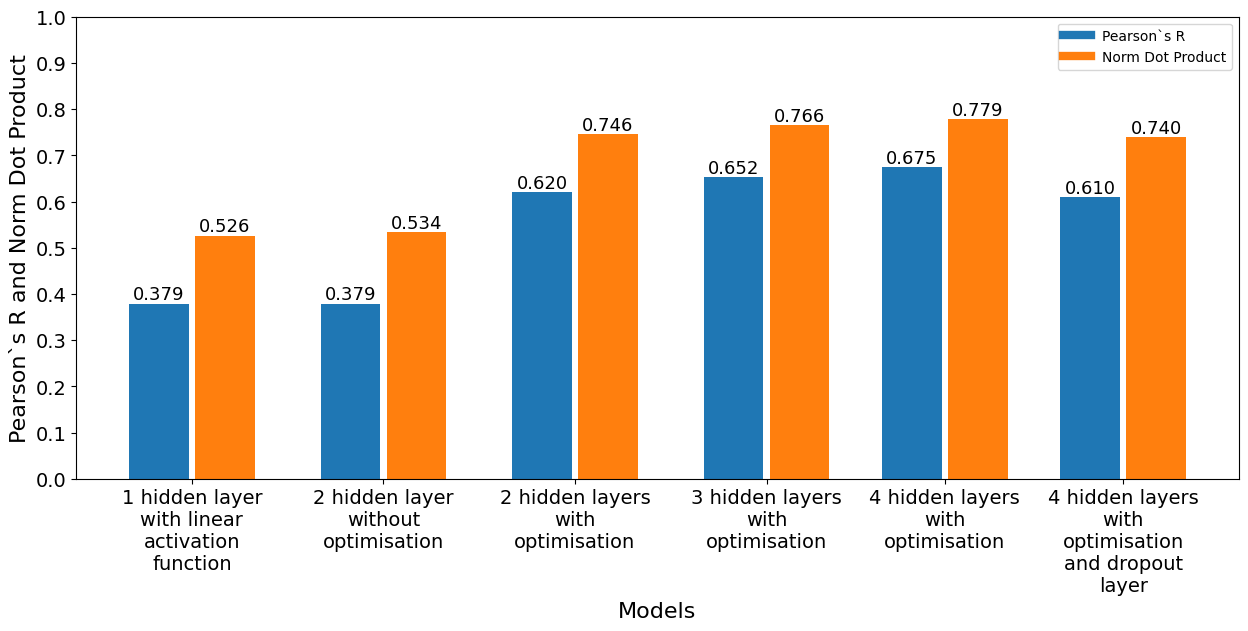

In [76]:
# Daten für die erste Gruppe von Säulen
x1 = np.array([1, 2])
y1 = np.array([0.379, 0.526])

# Daten für die zweite Gruppe von Säulen
x2 = np.array([3, 4])
y2 = np.array([0.379, 0.534])

# Daten für die dritte Gruppe von Säulen
x3 = np.array([5, 6])
y3 = np.array([0.620, 0.746])

# Daten für die vierte Gruppe von Säulen
x4 = np.array([7, 8])
y4 = np.array([0.652, 0.766])

# Daten für die fünfte Gruppe von Säulen
x5 = np.array([7, 8])
y5 = np.array([0.675, 0.779])

# Daten für die sechste Gruppe von Säulen
x6 = np.array([7, 8])
y6 = np.array([0.610, 0.740])


# Gesamtbreite
bar_width = 0.9

#Farben
colors2 = ['tab:blue', 'tab:orange']

# Größe der Grafik ändern (width, height) in Zoll
fig, ax = plt.subplots(figsize=(15, 6))

# Erste Gruppe von Säulen
bars1 = ax.bar(x1, y1, bar_width, color=colors2, label='Gruppe 1')

# Zweite Gruppe von Säulen
bars2 = ax.bar(x2 + bar_width, y2, bar_width, color=colors2, label='Gruppe 2')

# Dritte Gruppe von Säulen
bars3 = ax.bar(x3 + 2*bar_width, y3, bar_width, color=colors2)

# Vierte Gruppe von Säulen
bars4 = ax.bar(x4 + 3*bar_width, y4, bar_width, color=colors2)

# fünfte Gruppe von Säulen
bars5 = ax.bar(x5 + 6*bar_width, y5, bar_width, color=colors2)

# Vierte Gruppe von Säulen
bars6 = ax.bar(x6 + 9*bar_width, y6, bar_width, color=colors2)

# Achsenbeschriftungen und Legende
ax.set_xlabel('Models', fontsize=16)
ax.set_ylabel('Pearson`s R and Norm Dot Product', fontsize=16)

# Säulenlabels für jede Gruppe
group_positions = [x1[0] + (x1[-1] - x1[0]) / 2, 
                   x2[0] + (x2[-1] - x2[0]) / 2 + bar_width,
                   x3[0] + (x3[-1] - x3[0]) / 2 + 2 * bar_width,
                   x4[0] + (x4[-1] - x4[0]) / 2 + 3 * bar_width,
                   x5[0] + (x5[-1] - x5[0]) / 2 + 6 * bar_width,
                   x6[0] + (x6[-1] - x6[0]) / 2 + 9 * bar_width]
ax.set_xticks(group_positions)

# Text in den Labels in 2 Zeilen aufteilen, falls zu lang
labels = ['1 hidden layer with linear activation function', '2 hidden layer without optimisation', '2 hidden layers with optimisation', '3 hidden layers with optimisation', '4 hidden layers with optimisation', '4 hidden layers with optimisation and dropout layer']
wrapped_labels = [textwrap.fill(label, 15) for label in labels]
ax.set_xticklabels(wrapped_labels, fontsize=14)

# Setzen der y-Achsenbegrenzung zwischen 0 und 1
ax.set_ylim(0, 1)

# Text über den Säulen hinzufügen
for bar, value in zip(bars1, y1):
    ax.text(bar.get_x() + bar.get_width() / 2, value, f'{value:.3f}', ha='center', va='bottom', fontsize=13)

for bar, value in zip(bars2, y2):
    ax.text(bar.get_x() + bar.get_width() / 2, value, f'{value:.3f}', ha='center', va='bottom', fontsize=13)

for bar, value in zip(bars3, y3):
    ax.text(bar.get_x() + bar.get_width() / 2, value, f'{value:.3f}', ha='center', va='bottom', fontsize=13)

for bar, value in zip(bars4, y4):
    ax.text(bar.get_x() + bar.get_width() / 2, value, f'{value:.3f}', ha='center', va='bottom', fontsize=13)

for bar, value in zip(bars5, y5):
    ax.text(bar.get_x() + bar.get_width() / 2, value, f'{value:.3f}', ha='center', va='bottom', fontsize=13)
    
for bar, value in zip(bars6, y6):
    ax.text(bar.get_x() + bar.get_width() / 2, value, f'{value:.3f}', ha='center', va='bottom', fontsize=13)

# Änderung der Schriftgröße der Y-Achse
ax.tick_params(axis='y', labelsize=14)

# Festlegen der Intervalle für Y-Achsenticks auf 0.1
ax.yaxis.set_major_locator(MultipleLocator(0.1))

# Manuell die Legende erstellen
legend_handles = [plt.Line2D([0], [0], color=colors2[0], lw=6),
                  plt.Line2D([0], [0], color=colors2[1], lw=6)]
legend_labels = ['Pearson`s R', 'Norm Dot Product']
ax.legend(legend_handles, legend_labels)

# Anzeigen des Diagramms
plt.show()


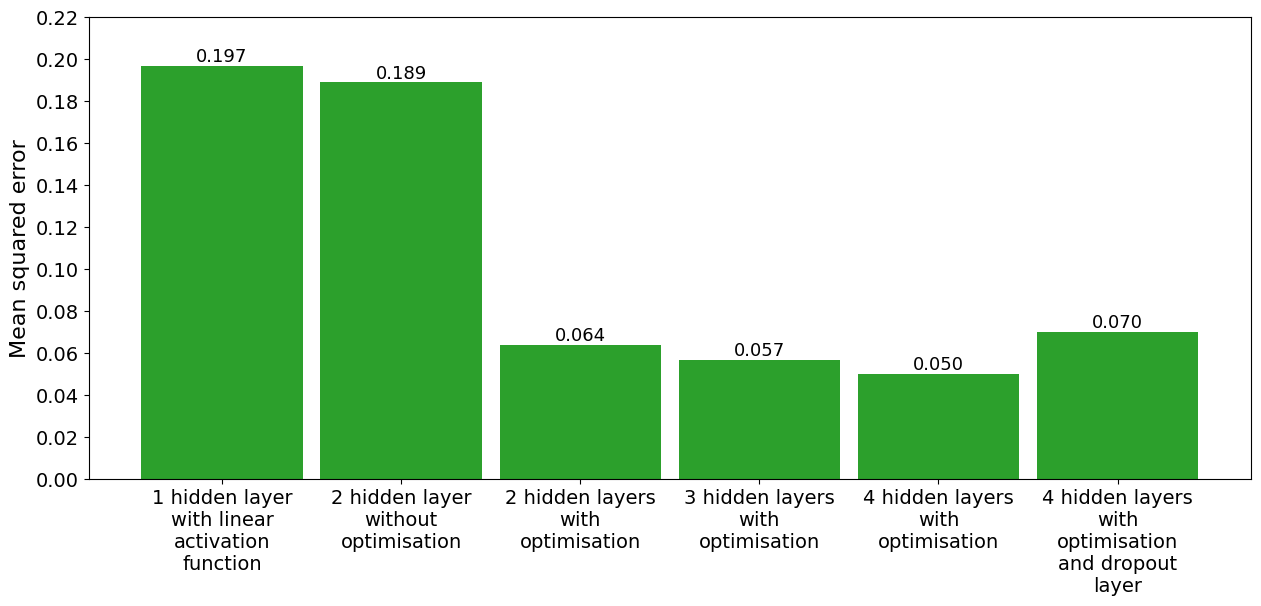

In [74]:
# Daten
x1 = np.array([1, 2, 3, 4, 5, 6])
y1 = np.array([0.197, 0.189, 0.064, 0.057, 0.050, 0.070])

# Gesamtbreite jeder Gruppe
bar_width = 0.9

# Farben für jede Säule
colors1 = ['tab:green', 'tab:green', 'tab:green', 'tab:green', 'tab:green', 'tab:green']

# Größe der Grafik ändern (width, height)
fig, ax = plt.subplots(figsize=(15, 6))

# Erste Gruppe von Säulen
bars1 = ax.bar(x1, y1, bar_width, color=colors1, label='Gruppe 1')

ax.set_ylabel('Mean squared error', fontsize=16)  # Änderung der Schriftgröße hier

# Säulenlabels
ax.set_xticks(np.concatenate([x1 + bar_width - 0.9]))
labels = ['1 hidden layer with linear activation function', '2 hidden layer without optimisation', '2 hidden layers with optimisation', '3 hidden layers with optimisation', '4 hidden layers with optimisation', '4 hidden layers with optimisation and dropout layer']

# Text in den Labels in 2 Zeilen aufteilen, falls zu lang
wrapped_labels = [textwrap.fill(label, 15) for label in labels]  # 15 ist die maximale Breite pro Zeile
ax.set_xticklabels(wrapped_labels, fontsize=14)  # Änderung der Schriftgröße

ax.set_ylim(0, 0.22)

# Text über den Säulen hinzufügen
for bar, value, label in zip(bars1, y1, labels):
    ax.text(bar.get_x() + bar.get_width() / 2, value, f'{value:.3f}', ha='center', va='bottom', fontsize=13)

# Änderung der Schriftgröße der Y-Achse
ax.tick_params(axis='y', labelsize=14)

# Festlegen der Intervalle 
ax.yaxis.set_major_locator(MultipleLocator(0.02))

# Anzeigen des Diagramms
plt.show()